Gene Ontology aided Compound Protein Binding
Affinity Prediction Using Neural Network

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate # type: ignore
from tensorflow.keras.layers import BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore
from keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import precision_recall_curve, auc

Loading data

In [3]:
df_davis = pd.read_csv("davis-filter.txt", header=None,sep = " ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])

In [4]:
#check for any missing values in train data
print(df_davis.isnull().any().sum())
df = df_davis
df

0


,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532
1,11314340,AKT1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,7.119186
2,11314340,AKT2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,5.537602
3,11314340,AKT3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,6.744727
4,11314340,AURKC,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIG...,5.075721
...,...,...,...,...,...
9120,151194,PDGFRB,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSET...,7.602060
9121,151194,RET(M918T),C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,5.119186
9122,151194,VEGFR2,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,7.207608
9123,151194,YSK4,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246


Using One-Hot encoding for SMILES and AMINO ACIDS sequence

In [5]:
#for amino acid sequence
# Step 1: Extract unique characters from the specified column ('amino_acid_seq')
unique_chars = sorted(set(''.join(df['amino_acid_seq'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['amino_acid_seq_encoded'] = df['amino_acid_seq'].apply(encode_sequence)

#for SMILES sequence
# Step 1: Extract unique characters from the specified column ('SMILES_seq_drug')
unique_chars = sorted(set(''.join(df['SMILES_seq_drug'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['SMILES_seq_drug_encoded'] = df['SMILES_seq_drug'].apply(encode_sequence)


Padding the amino acid and smiles sequences with 0's to ensure uniformity

In [6]:
# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['amino_acid_seq_encoded'], padding='post', value=0)

# Step 2: Truncate and assign the padded sequences back to the DataFrame
df['aa_seq_padded'] = list(padded_seqs)
max_length = 1200
df['aa_seq_padded'] = df['aa_seq_padded'].apply(lambda x: x[:max_length])

# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['SMILES_seq_drug_encoded'], padding='post', value=0)

# Step 2: Truncate and assign the padded sequences back to the DataFrame
df['smiles_seq_padded'] = list(padded_seqs)
max_length = 85
df['smiles_seq_padded'] = df['smiles_seq_padded'].apply(lambda x: x[:max_length])

df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score,amino_acid_seq_encoded,SMILES_seq_drug_encoded,aa_seq_padded,smiles_seq_padded
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532,"[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ..."
1,11314340,AKT1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,7.119186,"[11, 16, 3, 18, 1, 8, 18, 9, 4, 6, 19, 10, 7, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 1, 8, 18, 9, 4, 6, 19, 10, 7, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ..."
2,11314340,AKT2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,5.537602,"[11, 12, 4, 18, 16, 18, 8, 9, 4, 6, 19, 10, 7,...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 12, 4, 18, 16, 18, 8, 9, 4, 6, 19, 10, 7,...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ..."
3,11314340,AKT3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,6.744727,"[11, 16, 3, 18, 17, 8, 18, 9, 4, 6, 19, 18, 14...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 17, 8, 18, 9, 4, 6, 19, 18, 14...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ..."
4,11314340,AURKC,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIG...,5.075721,"[11, 16, 16, 13, 15, 1, 18, 18, 14, 10, 6, 9, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 16, 13, 15, 1, 18, 18, 14, 10, 6, 9, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ..."
...,...,...,...,...,...,...,...,...,...
9120,151194,PDGFRB,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSET...,7.602060,"[1, 1, 16, 4, 13, 3, 17, 1, 6, 16, 18, 15, 6, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[1, 1, 16, 4, 13, 3, 17, 1, 6, 16, 18, 15, 6, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ..."
9121,151194,RET(M918T),C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,5.119186,"[11, 1, 9, 1, 17, 16, 6, 1, 1, 6, 10, 15, 10, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 1, 9, 1, 17, 16, 6, 1, 1, 6, 10, 15, 10, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ..."
9122,151194,VEGFR2,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,7.207608,"[11, 14, 16, 9, 18, 10, 10, 1, 18, 1, 10, 19, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 14, 16, 9, 18, 10, 10, 1, 18, 1, 10, 19, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ..."
9123,151194,YSK4,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246,"[11, 16, 16, 11, 13, 9, 13, 4, 15, 7, 1, 4, 16...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 16, 16, 11, 13, 9, 13, 4, 15, 7, 1, 4, 16...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ..."


Train-test splitting – Case 2
New proteins in test:
90% proteins are present in the train, with all their drug interactions and remaining proteins with all their interactions are present in test



In [7]:

# Separate proteins into training and test sets (90% for training, 10% for testing)
train_proteins, test_proteins = train_test_split(df['protein_id'].unique(), test_size=0.1, random_state=42)

# Now we can create a train and test dataset by filtering the DataFrame based on the protein ids
train_df = df[df['protein_id'].isin(train_proteins)]
test_df = df[df['protein_id'].isin(test_proteins)]

# Shuffle the final train and test data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


Checking whether the split happened properly

In [8]:
print(train_df.shape)
print(test_df.shape)

train_list = train_df['protein_id'].unique()
test_list = test_df['protein_id'].unique()

for i in test_list:
    if(i in train_list): print("Error")
else: print("Split performed correctly")

(8271, 9)
(854, 9)
Split performed correctly


Building the Convolutional Neural Network

In [90]:
# Define the first neural network (Model 1)
input1 = Input(shape=(1200,))
x1 = Dense(300, activation='relu')(input1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(20, activation='relu')(x1)
x1 = BatchNormalization()(x1)

# Define the second neural network (Model 2)
input2 = Input(shape=(85,))

x2 = Dense(16, activation='relu')(input2)
x2 = BatchNormalization()(x2)

# Concatenate the outputs of the two models
concatenated = Concatenate()([x1, x2])

# Further layers after concatenation
x = Dense(16, activation='relu')(concatenated)
x = Dense(4, activation='relu')(x)

# Output layer
output = Dense(1, activation='linear')(x)

# Define the combined model using the Functional API
model = Model(inputs=[input1, input2], outputs=output)


Compiling the model

In [91]:
#Optimizer
optimizer = Adam(learning_rate=0.02, beta_1=0.9, beta_2=0.999 )

#Compiling the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 1200)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 300)       │    360,300 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300)       │      1,200 │ dense_70[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 300)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 20)        │      6,020 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 16)        │      1,376 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ dense_71[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_72[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 36)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 16)        │        592 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 4)         │         68 │ dense_73[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 1)         │          5 │ dense_74[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 369,705 (1.41 MB)

 Trainable params: 369,033 (1.41 MB)

 Non-trainable params: 672 (2.62 KB)

Training the model

In [92]:
aa_seq = pad_sequences(train_df['aa_seq_padded'], padding='post', dtype='int8')
smiles_seq = pad_sequences(train_df['smiles_seq_padded'], padding='post', dtype='int8')
x_train = [aa_seq, smiles_seq]
y_train = train_df['affinity_score']

aa_seq = pad_sequences(test_df['aa_seq_padded'], padding='post', dtype='int8')
smiles_seq = pad_sequences(test_df['smiles_seq_padded'], padding='post', dtype='int8')
x_test = [aa_seq, smiles_seq]
y_test = test_df['affinity_score']

batch_size = 300
epochs = 30

customLR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001, 
)

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_test, y_test), verbose=1, callbacks = [customLR, early_stopping])

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 14.5044 - mae: 3.0166 - val_loss: 1300.5441 - val_mae: 31.7204 - learning_rate: 0.0200
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1278 - mae: 0.8420 - val_loss: 126.0232 - val_mae: 10.3571 - learning_rate: 0.0200
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9823 - mae: 0.7770 - val_loss: 26.6860 - val_mae: 4.8083 - learning_rate: 0.0200
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9290 - mae: 0.7538 - val_loss: 8.6320 - val_mae: 2.6153 - learning_rate: 0.0200
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8936 - mae: 0.7391 - val_loss: 4.1952 - val_mae: 1.7707 - learning_rate: 0.0200
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8676 - mae: 0.7337 - val_loss: 3.7223 - val_mae: 1.6273 - learning_rate: 0.0200
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8597 - mae: 0.7270 - val_loss: 1.4151 - val_mae: 0.9943 - learning_rate: 0.0200
Epoc

Evaluating the Model

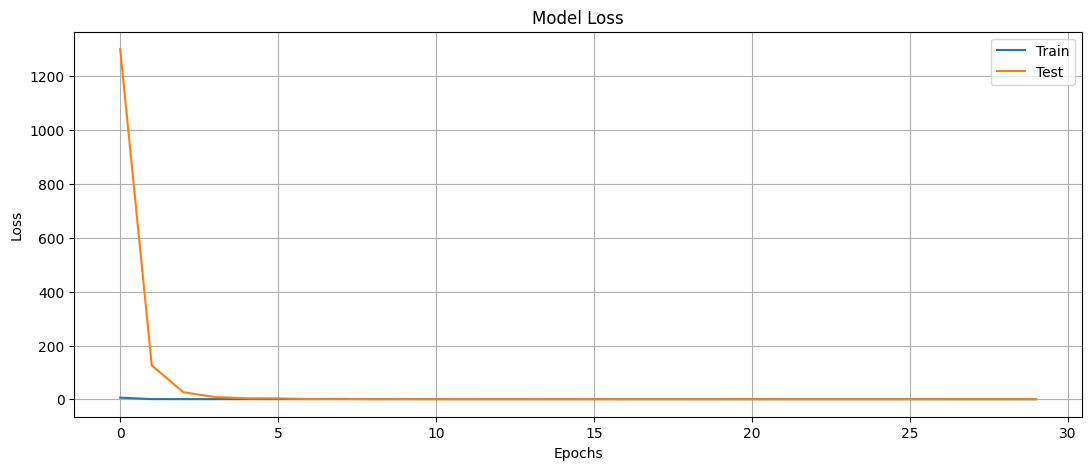

In [93]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

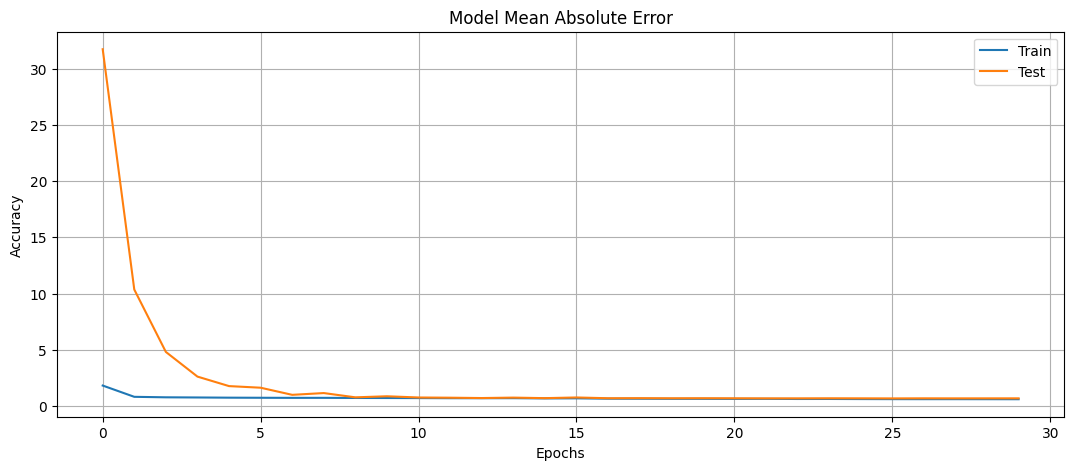

In [94]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

Measuring the performance of model

In [95]:
y_pred = model.predict(x_test).flatten()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [96]:
# Looking at the predictions
for i in range(len(y_pred)):
    print("actual: ", y_test[i], "predicted: ", y_pred[i])

actual:  5.2839966563652006 predicted:  5.9167805
actual:  8.494850021680094 predicted:  6.9071193
actual:  9.167491087293763 predicted:  7.4633255
actual:  6.508638306165728 predicted:  5.5968175
actual:  7.537602002101044 predicted:  7.2142987
actual:  6.327902142064283 predicted:  5.419844
actual:  5.698970004336019 predicted:  6.3538995
actual:  7.823908740944319 predicted:  6.890236
actual:  8.443697499232712 predicted:  7.4808426
actual:  5.619788758288394 predicted:  6.029792
actual:  6.853871964321762 predicted:  6.4539986
actual:  5.568636235841013 predicted:  6.383886
actual:  6.337242168318426 predicted:  6.5163665
actual:  5.221848749616356 predicted:  5.7239866
actual:  5.958607314841775 predicted:  6.333149
actual:  6.769551078621726 predicted:  6.225149
actual:  7.537602002101044 predicted:  6.4804835
actual:  7.721246399047171 predicted:  6.7576256
actual:  6.050609993355088 predicted:  5.9088726
actual:  7.744727494896694 predicted:  6.0934587
actual:  5.25181197299379

In [97]:

# Calculate the C-Index
ci = concordance_index(y_test, y_pred)
print("concordance index: " , ci)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("mean_squared_error: ", mse)

# Calculate pearson correlation
pearson_corr, p_value = pearsonr(y_test, y_pred)
print("pearson correlation: ", pearson_corr)

concordance index:  0.662932905513246
mean_squared_error:  0.7553300728767268
pearson correlation:  0.5354808767304429
